# Download Weather Data from WIFIRE Firemap

**What this notebook does:**
1. Define a location (lat/lon) and time window
2. Query WIFIRE Firemap for nearest weather station
3. Download wind speed and direction observations
4. Calculate mean values for FARSITE
5. Visualize wind patterns

**Data source:**
- [WIFIRE Firemap](https://firemap.sdsc.edu/) - Real-time weather station data
- Provides: wind speed (mph), wind direction (degrees)
- Time range: Up to 2 years of historical data

**Requirements:**
- Internet connection
- Location coordinates (lat/lon)
- Start and end times

---

## Setup

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from datetime import datetime, timedelta

print("✓ Imports loaded")

✓ Imports loaded


## 1. Define Location and Time Window

Specify where and when you want weather data:

In [2]:
# ========== USER INPUTS ==========

FIRE_NAME = "Border 2"              # For naming output files
QUERY_LAT = 32.601                  # Fire location latitude
QUERY_LON = -116.841                # Fire location longitude

START_TIME = "2025-01-23T13:53:00"  # Start of time window (ISO format)
END_TIME = "2025-01-24T13:53:00"    # End of time window (24 hours later)

OUTPUT_DIR = Path("weather_data")   # Where to save output

# ==================================

## 2. Query WIFIRE Firemap Weather API

Request data from the nearest weather station:

In [3]:
FIREMAP_WX_URL = "https://firemap.sdsc.edu/pylaski/stations/data"

params = {
    'selection': 'closestTo',
    'lat': str(QUERY_LAT),
    'lon': str(QUERY_LON),
    'observable': ['wind_speed', 'wind_direction'],
    'from': START_TIME,
    'to': END_TIME,
}

print(f"Querying weather near ({QUERY_LAT}, {QUERY_LON})...")
print(f"Time window: {START_TIME} to {END_TIME}")

response = requests.get(FIREMAP_WX_URL, params=params, timeout=30)
response.raise_for_status()

# Parse response (may have callback wrapper)
response_text = response.text.strip()
if response_text.startswith('wxData(') and response_text.endswith(')'):
    # Remove JSONP callback wrapper
    json_text = response_text[len('wxData('):-1]
    weather_data = json.loads(json_text)
else:
    weather_data = response.json()

print("✓ Data retrieved")

Querying weather near (32.601, -116.841)...
Time window: 2025-01-23T13:53:00 to 2025-01-24T13:53:00
✓ Data retrieved


## 3. Extract and Parse Observations

Get wind speed and direction from the response:

In [4]:
# Extract station info and observations
features = weather_data.get('features', [])

if not features:
    raise ValueError(
        f"No weather stations found near ({QUERY_LAT}, {QUERY_LON}).\n"
        f"Try a different location or time window."
    )

station = features[0]['properties']
station_name = station['description']['name']
station_id = station['description']['id']

# Get observation lists
wind_speed_list = station.get('wind_speed', [])
wind_direction_list = station.get('wind_direction', [])

print(f"\nStation: {station_name} (ID: {station_id})")
print(f"Observations: {len(wind_speed_list)} records")

if not wind_speed_list:
    raise ValueError("No wind speed data returned from station")


Station: OTAY MOUNTAIN (ID: 3414)
Observations: 24 records


## 4. Calculate Statistics

Compute mean, min, max, and standard deviation:

In [5]:
# Convert to arrays
wind_speeds = np.array(wind_speed_list)
wind_directions = np.array(wind_direction_list)

# Calculate statistics
stats = {
    'mean_wind_speed': float(np.mean(wind_speeds)),
    'mean_wind_direction': float(np.mean(wind_directions)),
    'min_wind_speed': float(np.min(wind_speeds)),
    'max_wind_speed': float(np.max(wind_speeds)),
    'std_wind_speed': float(np.std(wind_speeds)),
    'std_wind_direction': float(np.std(wind_directions)),
    'n_observations': len(wind_speeds),
    'station_name': station_name,
    'station_id': station_id,
    'query_location': {'lat': QUERY_LAT, 'lon': QUERY_LON},
    'time_window': {'start': START_TIME, 'end': END_TIME}
}

print("\n" + "="*60)
print("WEATHER STATISTICS")
print("="*60)
print(f"Wind Speed:")
print(f"  Mean: {stats['mean_wind_speed']:.2f} mph")
print(f"  Range: {stats['min_wind_speed']:.2f} - {stats['max_wind_speed']:.2f} mph")
print(f"  Std Dev: {stats['std_wind_speed']:.2f} mph")
print(f"\nWind Direction:")
print(f"  Mean: {stats['mean_wind_direction']:.1f}°")
print(f"  Std Dev: {stats['std_wind_direction']:.1f}°")
print(f"\nObservations: {stats['n_observations']} records")
print(f"Station: {station_name}")


WEATHER STATISTICS
Wind Speed:
  Mean: 10.36 mph
  Range: 4.47 - 15.20 mph
  Std Dev: 2.66 mph

Wind Direction:
  Mean: 87.0°
  Std Dev: 11.4°

Observations: 24 records
Station: OTAY MOUNTAIN


## 5. Save Data

Export observations and statistics:

In [6]:
OUTPUT_DIR.mkdir(exist_ok=True)

# Save raw observations as CSV
obs_df = pd.DataFrame({
    'wind_speed_mph': wind_speed_list,
    'wind_direction_deg': wind_direction_list
})

csv_file = OUTPUT_DIR / f"{FIRE_NAME.lower().replace(' ', '_')}_weather.csv"
obs_df.to_csv(csv_file, index=False)
print(f"\n✓ Saved observations to: {csv_file}")

# Save statistics as JSON
json_file = OUTPUT_DIR / f"{FIRE_NAME.lower().replace(' ', '_')}_weather_stats.json"
with open(json_file, 'w') as f:
    json.dump(stats, f, indent=2)
print(f"✓ Saved statistics to: {json_file}")

# Save complete response for reference
full_file = OUTPUT_DIR / f"{FIRE_NAME.lower().replace(' ', '_')}_weather_full.json"
with open(full_file, 'w') as f:
    json.dump(weather_data, f, indent=2)
print(f"✓ Saved full response to: {full_file}")


✓ Saved observations to: weather_data/border_2_weather.csv
✓ Saved statistics to: weather_data/border_2_weather_stats.json
✓ Saved full response to: weather_data/border_2_weather_full.json


## 6. Visualize Wind Patterns

Plot time series and wind rose:

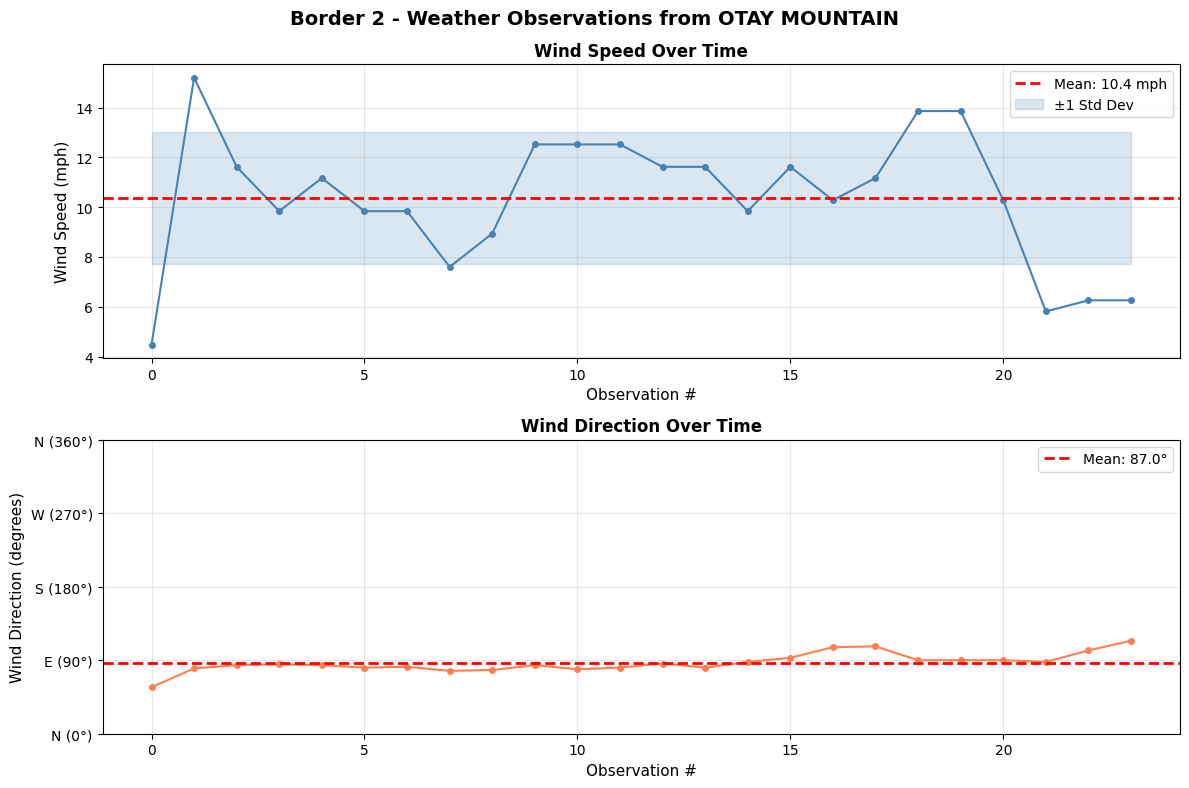

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Time series index
obs_index = np.arange(len(wind_speeds))

# 1. Wind speed over time
ax1.plot(obs_index, wind_speeds, marker='o', linewidth=1.5, markersize=4, color='steelblue')
ax1.axhline(stats['mean_wind_speed'], color='red', linestyle='--', linewidth=2, 
            label=f"Mean: {stats['mean_wind_speed']:.1f} mph")
ax1.fill_between(obs_index, 
                  stats['mean_wind_speed'] - stats['std_wind_speed'],
                  stats['mean_wind_speed'] + stats['std_wind_speed'],
                  alpha=0.2, color='steelblue', label=f"±1 Std Dev")
ax1.set_xlabel('Observation #', fontsize=11)
ax1.set_ylabel('Wind Speed (mph)', fontsize=11)
ax1.set_title('Wind Speed Over Time', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# 2. Wind direction over time
ax2.plot(obs_index, wind_directions, marker='o', linewidth=1.5, markersize=4, color='coral')
ax2.axhline(stats['mean_wind_direction'], color='red', linestyle='--', linewidth=2, 
            label=f"Mean: {stats['mean_wind_direction']:.1f}°")
ax2.set_xlabel('Observation #', fontsize=11)
ax2.set_ylabel('Wind Direction (degrees)', fontsize=11)
ax2.set_title('Wind Direction Over Time', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 360)
ax2.set_yticks([0, 90, 180, 270, 360])
ax2.set_yticklabels(['N (0°)', 'E (90°)', 'S (180°)', 'W (270°)', 'N (360°)'])
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.suptitle(f"{FIRE_NAME} - Weather Observations from {station_name}", 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Summary

**Downloaded files:**
```
weather_data/
├── <fire_name>_weather.csv           # Raw observations (speed, direction)
├── <fire_name>_weather_stats.json    # Summary statistics
└── <fire_name>_weather_full.json     # Complete API response
```

**Next steps: Use as parameters in a FARSITE simulation!**


**Notes:**
- Weather stations: HPWREN, SDG&E, and Synoptic
- Weather forecast: NOAA, NWS, NDFD, and HRRR


**Reference:**
- [WIFIRE Firemap F.A.Q.](https://wifire.ucsd.edu/firemap-faq)